In [1]:
# import timm
# import torch

# # ViT Tiny Patch16 224 モデルの作成
# model = timm.create_model(
#     "vit_tiny_patch16_224",  # モデル名
#     pretrained=False,        # 必要なら True
#     in_chans=3,              # 入力チャネル数
#     features_only=True,      # 各段階の特徴マップを取得
# )

# # ダミー入力 (例: B=1, C=3, H=224, W=224)
# x = torch.randn(1, 3, 224, 224)

# # 各段の出力を取得
# features = model(x)

# # 出力の形状を確認
# for i, f in enumerate(features):
#     print(f"Stage {i}: {f.shape}")

In [2]:
import os
import zarr
import timm
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

In [3]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
    augmentation=True,
    slice=True,
    pre_read=True,
)

# train_nshuffle_dataset = EziiDataset(
#     exp_names=CFG.train_exp_names,
#     base_dir="/home/tumeda/workspace/kaggle/CZII_2/20. kaggle/train/",
#     particles_name=CFG.particles_name,
#     resolution=CFG.resolution,
#     zarr_type=CFG.train_zarr_types,
#     augmentation=False,
#     train=True,
# )

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    augmentation=False,
    train=True,
    slice=True,
    pre_read=True,
)

from tqdm import tqdm

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=CFG.num_workers,
)
# train_nshuffle_loader = DataLoader(
#     train_nshuffle_dataset,
#     batch_size=1,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=CFG.num_workers,
)

for data in tqdm(train_loader):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    # ここでチャンネル次元を挿入
    normalized_tomogram = normalized_tomogram.unsqueeze(2)  # => (4,16,1,64,64)
    break

normalized_tomogram.shape

  0%|          | 0/300 [00:02<?, ?it/s]


torch.Size([4, 16, 1, 64, 64])

In [4]:
train_dataset[0]["segmentation_map"].shape

(16, 64, 64)

In [5]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder)  # .to("cuda") # 確認用なのでGPUに載せない
# model.load_state_dict(torch.load("./pretrained_model.pth"))
# model.load_state_dict(torch.load("./best_model.pth"))

RuntimeError: features_only not implemented for Vision Transformer models.

In [7]:
# input-test

x = torch.randn(2, 16, 1, 64, 64).cuda()
model(x).shape
# 例: バッチサイズ=2, 深さ=16, 1ch, H=W=64
# x = torch.randn(2, 16, 1, 64, 64).cuda()
# out = model(x)   # ここで forward が走る
# print(out.shape)

ValueError: not enough values to unpack (expected 4, got 2)

In [7]:
# # "encoder"と名のつくパラメータは学習しない
# for layer, param in model.named_parameters():
#     if "encoder" in layer:
#         param.requires_grad = False

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [9]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 12, 12),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    if random.random() < p:
        tomogram, segmentation_map = mixup(
            tomogram, segmentation_map, alpha=mixup_alpha
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 320, 320])


In [8]:
from transformers import get_cosine_schedule_with_warmup

optimizer = torch.optim.Adam(
    model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
)
criterion = nn.CrossEntropyLoss(
    #  weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=10,
    num_training_steps=CFG.epochs * len(train_loader),
    # * batch_size,
)
scaler = GradScaler()
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

In [9]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [10]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor

In [11]:
padf = PadToSize(CFG.resolution)
padf(normalized_tomogram).shape

torch.Size([4, 16, 1, 64, 64])

In [12]:
best_model = None
best_constant = 0
best_score = -100

grand_train_loss = []
grand_valid_loss = []
grand_train_score = []
grand_valid_score = []

for epoch in range(CFG.epochs):
    model.train()
    train_loss = []
    valid_loss = []
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"]
            segmentation_map = data["segmentation_map"]

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            # データ拡張
            # normalized_tomogram, segmentation_map = augment_data(
            #     normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
            # )
            normalized_tomogram = normalized_tomogram.cuda()
            segmentation_map = segmentation_map.long().cuda()

            optimizer.zero_grad()

            with autocast():
                pred = model(preprocess_tensor(normalized_tomogram))
                loss = seg_loss(pred, segmentation_map)
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

    with tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]") as tq:
        with torch.no_grad():
            for data in tq:
                normalized_tomogram = data["normalized_tomogram"].cuda()
                segmentation_map = data["segmentation_map"].long().cuda()

                normalized_tomogram = padf(normalized_tomogram)
                segmentation_map = padf(segmentation_map)

                with autocast():
                    pred = model(preprocess_tensor(normalized_tomogram))
                    loss = seg_loss(pred, segmentation_map)
                valid_loss.append(loss.item())

                # 確率予測
                prob_pred = torch.softmax(pred, dim=1)
                tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

    # # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # モデルの保存
    torch.save(model.state_dict(), "./best_model.pth")

    # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    train_inferenced_array = {}
    train_pred_array = []
    train_gt_array = []
    valid_inferenced_array = {}
    valid_gt_array = []

    # for exp_name in tqdm(CFG.train_exp_names):
    for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
        # inferenced_array = inference(model, exp_name, train=False)
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=False
        )
        valid_inferenced_array[exp_name] = inferenced_array
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])
        valid_gt_array.append(gt_df)

    valid_gt_array = pd.concat(valid_gt_array)

    b_constant = 0
    b_score = -100
    for constant in tqdm(np.linspace(0.1, 0.9, 15)):
        valid_pred_array = []
        sikii = {
            "apo-ferritin": constant,
            "beta-amylase": constant,
            "beta-galactosidase": constant,
            "ribosome": constant,
            "thyroglobulin": constant,
            "virus-like-particle": constant,
        }
        for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
            pred_df = inference2pos(
                pred_segmask=valid_inferenced_array[exp_name],
                exp_name=exp_name,
                sikii_dict=sikii,
            )
            valid_pred_array.append(pred_df)

        valid_pred_array = pd.concat(valid_pred_array)

        if len(valid_pred_array) != 0:
            score_ = score(
                valid_pred_array,
                valid_gt_array,
                row_id_column_name="index",
                distance_multiplier=1.0,
                beta=4,
            )
            if score_ > b_score:
                b_score = score_
                b_constant = constant

        import gc
        import torch.cuda as cuda

        gc.collect()
        cuda.empty_cache()

    print("constant", b_constant, "score", b_score)

    if b_score > best_score:
        best_constant = b_constant
        best_score = b_score
        # best_score = np.mean(valid_mean_scores)
        best_model = model.state_dict()
        torch.save(best_model, f"./best_model.pth")

    print(
        f"train-epoch-loss:{np.mean(train_loss):.4f}",
        f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
        # f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
        f"valid-beta4-score:{b_score:.4f}",
    )

    grand_train_loss.append(np.mean(train_loss))
    grand_valid_loss.append(np.mean(valid_loss))
    # grand_train_score.append(np.mean(train_mean_scores))
    grand_valid_score.append(b_score)

Epoch 1/80 [Training]:   0%|          | 0/300 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 4, got 2)

Epoch 1/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s, loss=0.1691]


New best model saved with validation loss: 0.1691
Epoch 1/80 Summary:
Train Loss: 0.2251, Valid Loss: 0.1691, Best Validation Loss: 0.1691


Epoch 2/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s, loss=0.0508]


New best model saved with validation loss: 0.0508
Epoch 2/80 Summary:
Train Loss: 0.0615, Valid Loss: 0.0508, Best Validation Loss: 0.0508


Epoch 3/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, loss=0.0742]


Epoch 3/80 Summary:
Train Loss: 0.0440, Valid Loss: 0.0742, Best Validation Loss: 0.0508


Epoch 4/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s, loss=0.0388]


New best model saved with validation loss: 0.0388
Epoch 4/80 Summary:
Train Loss: 0.0352, Valid Loss: 0.0388, Best Validation Loss: 0.0388


Epoch 5/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s, loss=0.0122]


New best model saved with validation loss: 0.0122
Epoch 5/80 Summary:
Train Loss: 0.0297, Valid Loss: 0.0122, Best Validation Loss: 0.0122


Epoch 6/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s, loss=0.0103]


New best model saved with validation loss: 0.0103
Epoch 6/80 Summary:
Train Loss: 0.0247, Valid Loss: 0.0103, Best Validation Loss: 0.0103


Epoch 7/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, loss=0.0138]


Epoch 7/80 Summary:
Train Loss: 0.0222, Valid Loss: 0.0138, Best Validation Loss: 0.0103


Epoch 8/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s, loss=0.0042]


New best model saved with validation loss: 0.0042
Epoch 8/80 Summary:
Train Loss: 0.0175, Valid Loss: 0.0042, Best Validation Loss: 0.0042


Epoch 9/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, loss=0.0027]


New best model saved with validation loss: 0.0027
Epoch 9/80 Summary:
Train Loss: 0.0174, Valid Loss: 0.0027, Best Validation Loss: 0.0027


Epoch 10/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, loss=0.0068]


Epoch 10/80 Summary:
Train Loss: 0.0170, Valid Loss: 0.0068, Best Validation Loss: 0.0027


Epoch 11/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s, loss=0.0012]


New best model saved with validation loss: 0.0012
Epoch 11/80 Summary:
Train Loss: 0.0143, Valid Loss: 0.0012, Best Validation Loss: 0.0012


Epoch 12/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, loss=0.0022]


Epoch 12/80 Summary:
Train Loss: 0.0146, Valid Loss: 0.0022, Best Validation Loss: 0.0012


Epoch 13/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s, loss=0.0043]


Epoch 13/80 Summary:
Train Loss: 0.0129, Valid Loss: 0.0043, Best Validation Loss: 0.0012


Epoch 14/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, loss=0.0013]


Epoch 14/80 Summary:
Train Loss: 0.0146, Valid Loss: 0.0013, Best Validation Loss: 0.0012


Epoch 15/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, loss=0.0022]


Epoch 15/80 Summary:
Train Loss: 0.0153, Valid Loss: 0.0022, Best Validation Loss: 0.0012


Epoch 16/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, loss=0.0016]


Epoch 16/80 Summary:
Train Loss: 0.0124, Valid Loss: 0.0016, Best Validation Loss: 0.0012


Epoch 17/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s, loss=0.0003]


New best model saved with validation loss: 0.0003
Epoch 17/80 Summary:
Train Loss: 0.0118, Valid Loss: 0.0003, Best Validation Loss: 0.0003


Epoch 18/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s, loss=0.0010]


Epoch 18/80 Summary:
Train Loss: 0.0106, Valid Loss: 0.0010, Best Validation Loss: 0.0003


Epoch 19/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s, loss=0.0002]


New best model saved with validation loss: 0.0002
Epoch 19/80 Summary:
Train Loss: 0.0099, Valid Loss: 0.0002, Best Validation Loss: 0.0002


Epoch 20/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s, loss=0.0012]


Epoch 20/80 Summary:
Train Loss: 0.0103, Valid Loss: 0.0012, Best Validation Loss: 0.0002


Epoch 21/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, loss=0.0003]


Epoch 21/80 Summary:
Train Loss: 0.0098, Valid Loss: 0.0003, Best Validation Loss: 0.0002


Epoch 22/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s, loss=0.0011]


Epoch 22/80 Summary:
Train Loss: 0.0104, Valid Loss: 0.0011, Best Validation Loss: 0.0002


Epoch 23/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, loss=0.0015]


Epoch 23/80 Summary:
Train Loss: 0.0094, Valid Loss: 0.0015, Best Validation Loss: 0.0002


Epoch 24/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, loss=0.0011]


Epoch 24/80 Summary:
Train Loss: 0.0096, Valid Loss: 0.0011, Best Validation Loss: 0.0002


Epoch 25/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s, loss=0.0007]


Epoch 25/80 Summary:
Train Loss: 0.0092, Valid Loss: 0.0007, Best Validation Loss: 0.0002


Epoch 26/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s, loss=0.0003]


Epoch 26/80 Summary:
Train Loss: 0.0073, Valid Loss: 0.0003, Best Validation Loss: 0.0002


Epoch 27/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, loss=0.0005]


Epoch 27/80 Summary:
Train Loss: 0.0088, Valid Loss: 0.0005, Best Validation Loss: 0.0002


Epoch 28/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s, loss=0.0003]


Epoch 28/80 Summary:
Train Loss: 0.0065, Valid Loss: 0.0003, Best Validation Loss: 0.0002


Epoch 29/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, loss=0.0004]


Epoch 29/80 Summary:
Train Loss: 0.0065, Valid Loss: 0.0004, Best Validation Loss: 0.0002


Epoch 30/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s, loss=0.0002]


Epoch 30/80 Summary:
Train Loss: 0.0085, Valid Loss: 0.0002, Best Validation Loss: 0.0002


Epoch 31/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s, loss=0.0004]


Epoch 31/80 Summary:
Train Loss: 0.0052, Valid Loss: 0.0004, Best Validation Loss: 0.0002


Epoch 32/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, loss=0.0002]


Epoch 32/80 Summary:
Train Loss: 0.0048, Valid Loss: 0.0002, Best Validation Loss: 0.0002


Epoch 33/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s, loss=0.0002]


Epoch 33/80 Summary:
Train Loss: 0.0069, Valid Loss: 0.0002, Best Validation Loss: 0.0002


Epoch 34/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s, loss=0.0002]


Epoch 34/80 Summary:
Train Loss: 0.0044, Valid Loss: 0.0002, Best Validation Loss: 0.0002


Epoch 35/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, loss=0.0003]


Epoch 35/80 Summary:
Train Loss: 0.0033, Valid Loss: 0.0003, Best Validation Loss: 0.0002


Epoch 36/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s, loss=0.0001]


New best model saved with validation loss: 0.0001
Epoch 36/80 Summary:
Train Loss: 0.0040, Valid Loss: 0.0001, Best Validation Loss: 0.0001


Epoch 37/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, loss=0.0001]


Epoch 37/80 Summary:
Train Loss: 0.0058, Valid Loss: 0.0001, Best Validation Loss: 0.0001


Epoch 38/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s, loss=0.0001]


Epoch 38/80 Summary:
Train Loss: 0.0031, Valid Loss: 0.0001, Best Validation Loss: 0.0001


Epoch 39/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s, loss=0.0022]


Epoch 39/80 Summary:
Train Loss: 0.0025, Valid Loss: 0.0022, Best Validation Loss: 0.0001


Epoch 40/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, loss=0.0001]


Epoch 40/80 Summary:
Train Loss: 0.0037, Valid Loss: 0.0001, Best Validation Loss: 0.0001


Epoch 41/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s, loss=0.0000]


New best model saved with validation loss: 0.0000
Epoch 41/80 Summary:
Train Loss: 0.0022, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 42/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, loss=0.0001]


Epoch 42/80 Summary:
Train Loss: 0.0024, Valid Loss: 0.0001, Best Validation Loss: 0.0000


Epoch 43/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, loss=0.0000]


New best model saved with validation loss: 0.0000
Epoch 43/80 Summary:
Train Loss: 0.0056, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 44/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s, loss=0.0000]


Epoch 44/80 Summary:
Train Loss: 0.0023, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 45/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s, loss=0.0000]


Epoch 45/80 Summary:
Train Loss: 0.0017, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 46/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, loss=0.0001]


Epoch 46/80 Summary:
Train Loss: 0.0016, Valid Loss: 0.0001, Best Validation Loss: 0.0000


Epoch 47/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s, loss=0.0000]


Epoch 47/80 Summary:
Train Loss: 0.0020, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 48/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, loss=0.0001]


Epoch 48/80 Summary:
Train Loss: 0.0014, Valid Loss: 0.0001, Best Validation Loss: 0.0000


Epoch 49/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s, loss=0.0001]


Epoch 49/80 Summary:
Train Loss: 0.0023, Valid Loss: 0.0001, Best Validation Loss: 0.0000


Epoch 50/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s, loss=0.0000]


New best model saved with validation loss: 0.0000
Epoch 50/80 Summary:
Train Loss: 0.0009, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 51/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s, loss=0.0000]


Epoch 51/80 Summary:
Train Loss: 0.0011, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 52/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s, loss=0.0000]


New best model saved with validation loss: 0.0000
Epoch 52/80 Summary:
Train Loss: 0.0012, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 53/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s, loss=0.0000]


Epoch 53/80 Summary:
Train Loss: 0.0009, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 54/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s, loss=0.0000]


Epoch 54/80 Summary:
Train Loss: 0.0007, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 55/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s, loss=0.0000]


Epoch 55/80 Summary:
Train Loss: 0.0011, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 56/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, loss=0.0000]


Epoch 56/80 Summary:
Train Loss: 0.0009, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 57/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s, loss=0.0000]


Epoch 57/80 Summary:
Train Loss: 0.0007, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 58/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, loss=0.0001]


Epoch 58/80 Summary:
Train Loss: 0.0009, Valid Loss: 0.0001, Best Validation Loss: 0.0000


Epoch 59/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s, loss=0.0000]


Epoch 59/80 Summary:
Train Loss: 0.0021, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 60/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, loss=0.0000]


Epoch 60/80 Summary:
Train Loss: 0.0004, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 61/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s, loss=0.0000]


New best model saved with validation loss: 0.0000
Epoch 61/80 Summary:
Train Loss: 0.0003, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 62/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s, loss=0.0000]


Epoch 62/80 Summary:
Train Loss: 0.0004, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 63/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s, loss=0.0000]


New best model saved with validation loss: 0.0000
Epoch 63/80 Summary:
Train Loss: 0.0004, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 64/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s, loss=0.0000]


New best model saved with validation loss: 0.0000
Epoch 64/80 Summary:
Train Loss: 0.0002, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 65/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s, loss=0.0000]


Epoch 65/80 Summary:
Train Loss: 0.0002, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 66/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s, loss=0.0000]


Epoch 66/80 Summary:
Train Loss: 0.0002, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 67/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s, loss=0.0000]


New best model saved with validation loss: 0.0000
Epoch 67/80 Summary:
Train Loss: 0.0002, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 68/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, loss=0.0000]


Epoch 68/80 Summary:
Train Loss: 0.0002, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 69/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s, loss=0.0000]


Epoch 69/80 Summary:
Train Loss: 0.0001, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 70/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s, loss=0.0000]


Epoch 70/80 Summary:
Train Loss: 0.0001, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 71/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, loss=0.0000]


Epoch 71/80 Summary:
Train Loss: 0.0001, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 72/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, loss=0.0000]


Epoch 72/80 Summary:
Train Loss: 0.0001, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 73/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s, loss=0.0000]


Epoch 73/80 Summary:
Train Loss: 0.0001, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 74/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s, loss=0.0000]


Epoch 74/80 Summary:
Train Loss: 0.0001, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 75/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s, loss=0.0000]


Epoch 75/80 Summary:
Train Loss: 0.0001, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 76/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, loss=0.0000]


Epoch 76/80 Summary:
Train Loss: 0.0001, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 77/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s, loss=0.0000]


Epoch 77/80 Summary:
Train Loss: 0.0001, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 78/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s, loss=0.0000]


Epoch 78/80 Summary:
Train Loss: 0.0001, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 79/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s, loss=0.0000]


Epoch 79/80 Summary:
Train Loss: 0.0001, Valid Loss: 0.0000, Best Validation Loss: 0.0000


Epoch 80/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s, loss=0.0000]


Epoch 80/80 Summary:
Train Loss: 0.0001, Valid Loss: 0.0000, Best Validation Loss: 0.0000


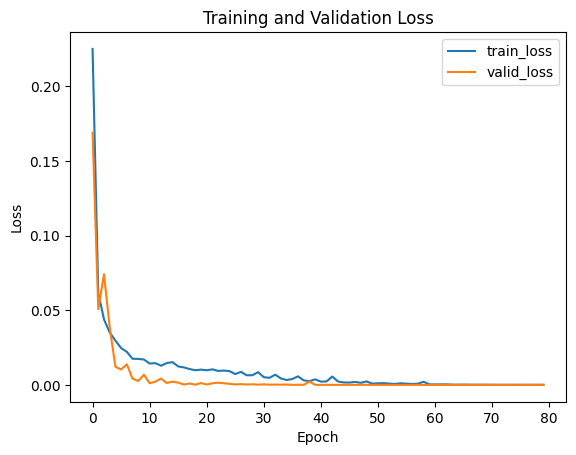

In [18]:
# scoreなし ver.
# best_model = None
# best_constant = 0
# best_score = -100

# grand_train_loss = []
# grand_valid_loss = []

# for epoch in range(CFG.epochs):
#     model.train()
#     train_loss = []
#     valid_loss = []
#     with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]") as tq:
#         for data in tq:
#             normalized_tomogram = data["normalized_tomogram"]
#             segmentation_map = data["segmentation_map"]

#             normalized_tomogram = padf(normalized_tomogram)
#             segmentation_map = padf(segmentation_map)

#             normalized_tomogram = normalized_tomogram.cuda()
#             segmentation_map = segmentation_map.long().cuda()

#             optimizer.zero_grad()

#             with autocast():
#                 pred = model(preprocess_tensor(normalized_tomogram))
#                 loss = seg_loss(pred, segmentation_map)

#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             scheduler.step()
#             train_loss.append(loss.item())

#             tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

#     with tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]") as tq:
#         for data in tq:
#             normalized_tomogram = data["normalized_tomogram"].cuda()
#             segmentation_map = data["segmentation_map"].long().cuda()

#             normalized_tomogram = padf(normalized_tomogram)
#             segmentation_map = padf(segmentation_map)

#             with autocast():
#                 pred = model(preprocess_tensor(normalized_tomogram))
#                 loss = seg_loss(pred, segmentation_map)

#             valid_loss.append(loss.item())
#             tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

#     # 損失値を記録
#     train_epoch_loss = np.mean(train_loss)
#     valid_epoch_loss = np.mean(valid_loss)
#     grand_train_loss.append(train_epoch_loss)
#     grand_valid_loss.append(valid_epoch_loss)

#     # ベストモデルを保存
#     if valid_epoch_loss < best_score or best_score == -100:
#         best_score = valid_epoch_loss
#         best_model = model.state_dict()
#         torch.save(best_model, "final_model.pth")
#         print(f"New best model saved with validation loss: {best_score:.4f}")

#     print(
#         f"Epoch {epoch + 1}/{CFG.epochs} Summary:\n"
#         f"Train Loss: {train_epoch_loss:.4f}, "
#         f"Valid Loss: {valid_epoch_loss:.4f}, "
#         f"Best Validation Loss: {best_score:.4f}"
#     )

# # train_lossとvalid_lossのプロット
# plt.plot(grand_train_loss, label="train_loss")
# plt.plot(grand_valid_loss, label="valid_loss")
# plt.legend()
# plt.title("Training and Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.show()

In [16]:
# # train_lossとvalid_lossのプロット

# plt.plot(grand_train_loss, label="train_loss")
# plt.plot(grand_valid_loss, label="valid_loss")
# plt.legend()
# plt.show()

In [ ]:
# # train_scoreとvalid_scoreのプロット
# plt.plot(grand_train_score, label="train_score")
# plt.plot(grand_valid_score, label="valid_score")
# plt.legend()
# plt.show()

In [18]:
# normalized_tomogram.shape

torch.Size([4, 16, 64, 64])

In [ ]:
# x = np.random.randn(1, 16, 1, 320, 320)

# x[0, :, 0, :0, :0].shape

(16, 0, 0)

In [20]:
# normalized_tomogram = data["normalized_tomogram"]
# segmentation_map = data["segmentation_map"]